<a href="https://colab.research.google.com/github/sophiarobert/Curvature-Model/blob/main/DSPN_SRobert_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DSPN Final Project Spring 2021
---
# Hemispheric Reorganization after Cortical Resection: Four Case Studies

#### Background
According to the [CDC](https://https://www.cdc.gov/epilepsy/data/index.html), 1.2% or 3.4 million people in the US currently suffer from epilepsy and of those, 30-40% have [refractory seizures](https://10.1016/j.yebeh.2014.05.031), or seizures that are unresponsive to medications or other treatments. One option that is presented as a last resort to patients with medically refractory seizures is to have surgery to resect the epileptogenic tissue, essentially removing brain regions that the seizures start from. This kind of procedure has a [40-80% success rate](https://10.1111/epi.13920) in alleviating seizures in the long term. The impact of resection on the functioning of the brain is of particular interest to cognitive neuroscientists because it allows us to study its robustness to perturbation and capacity for reorganization and compensation ([Liu et al., 2019](https://doi.org/10.1523/JNEUROSCI.3160-18.2019)). One possibile mechanism that might faciliate remapping or compensation is through children in the connectivity between the remaining or intact brain areas. Previous neuroimaging research on functional reorganization after cortical resection in children has focused on specific domains, e.g., memory, language, and motor control, with high controlled paradigms using targetted behavioral tasks. The focus on a narrow domain, however, does not permit the investigation of wide-scale cortical reorganization.   

#### Study Design
Using a naturalistic viewing paradigm such as movie watching drives dynamic, multi-modal processing in the whole brain and increases the signal-to-noise ratio relative to standard resting state data so that differences between subjects can be more easily discerned. Thus, in this study, patients with unilateral cortical resections (n = 4, age range: 7-22) and age-matched controls (n = 27, age range: 9-32) viewed an 11-minute segment of a movie as BOLD responses were recorded with functional MRI. Using an anatomical parcellation ([Glasser atlas](https://10.1038/nature18933)), we divided the brain into 180 parcels per hemisphere and, primarily for ease of analysis, averaged the timecourses of all of the voxels in each parcel to produce 180 timecourses per hemisphere. Because of the distortion of the brain tissue in the resected hemisphere, we will be investigating the organization of the contralesional or intact hemisphere. Each patient was age- and hemisphere-matched with a subset of the controls. Due to the heterogeneity of the patient population (see table below) and our low sample size, each patient will be compared to their age- and hemisphere matched controls individually as independent case studies. 



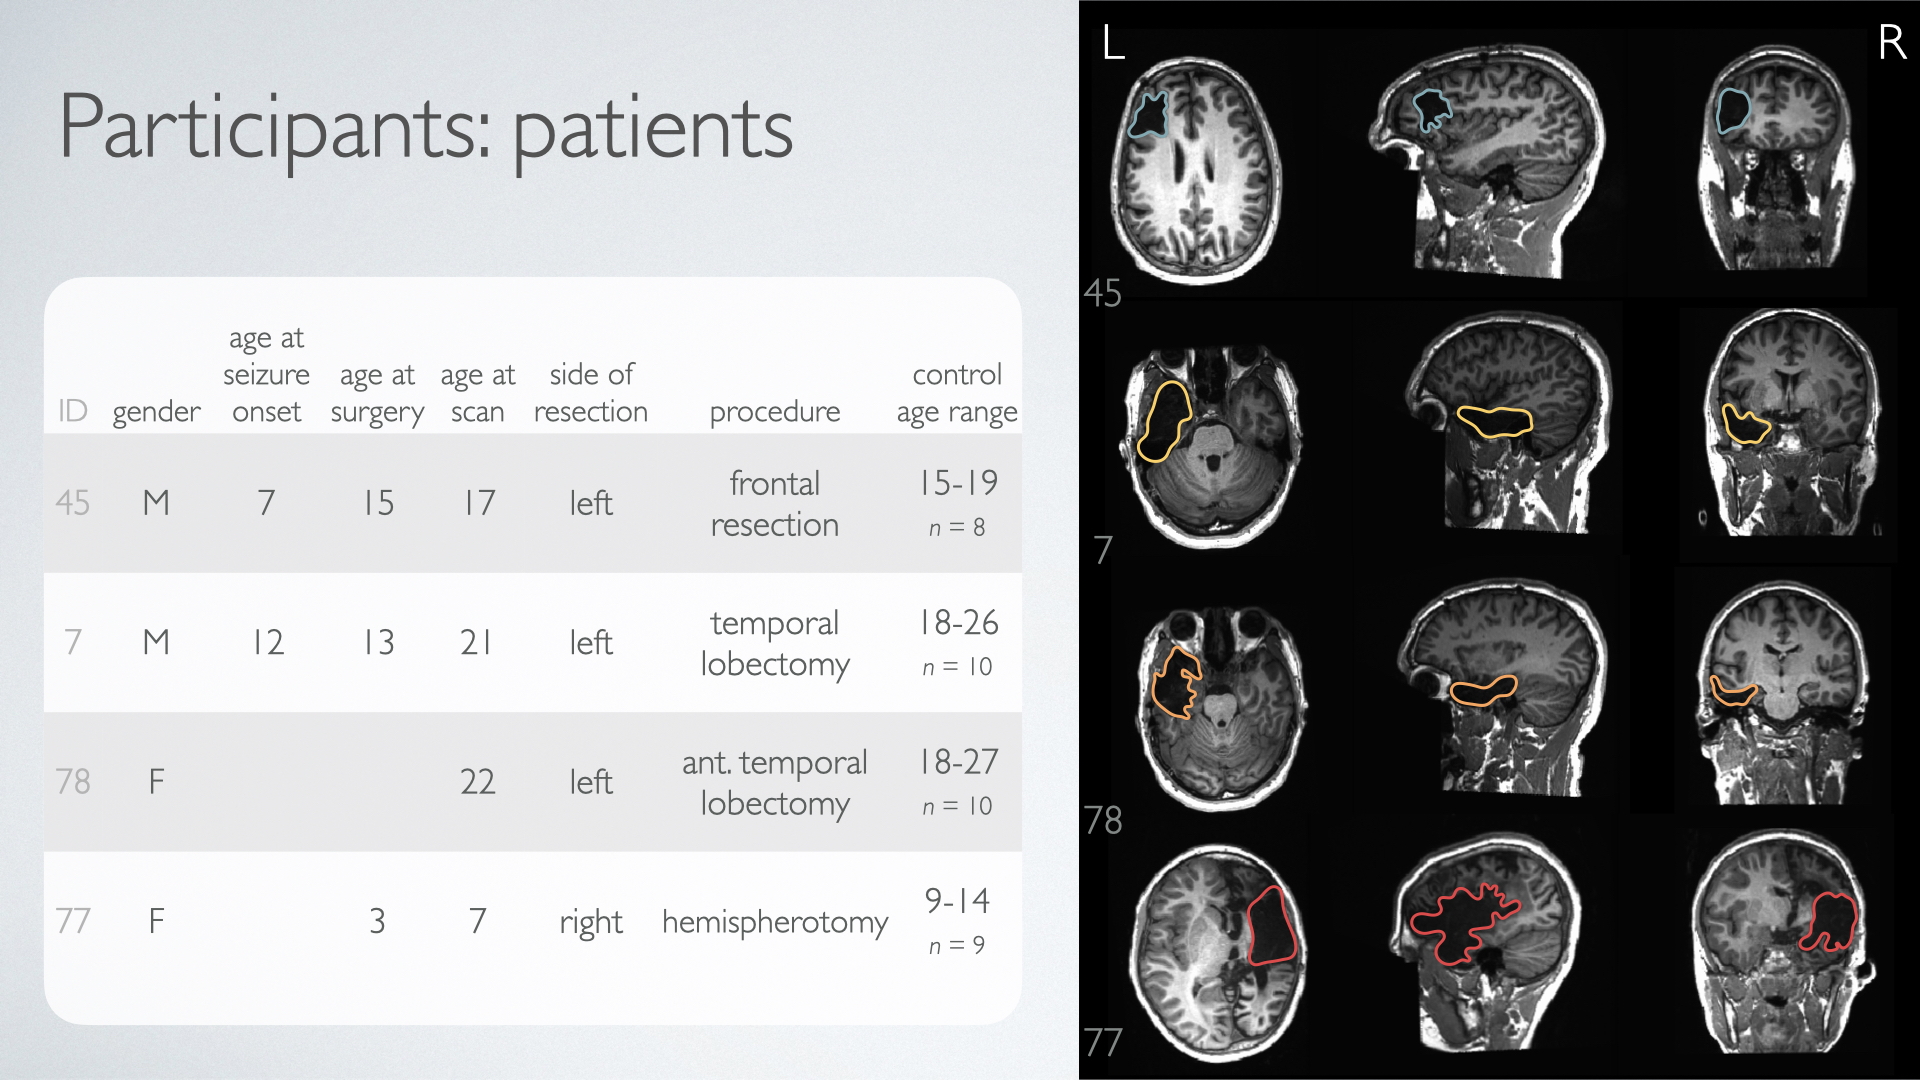

#### Specific Aims
How the organization of the intact hemisphere in patients with cortical resections is able to accomodate typical behavioral performance in a myriad of cognitive tasks remains poorly understood. Because we are interested in broad-scale changes that might be occurring across the whole brain as an interconnected network, we will adopt the graph theoretical terms $nodes$ and $edges$ to refer to the brain parcels and their relationships, respectively. Here I will be presenting 3 preliminary exploratory analyses to determine if and how these patients might differ from controls on three levels of organization, *with the null hypothesis that the patients fall within the distribution of their matched controls in each of the three metrics*. 

1.   `Average Node Activity` taking the average activation of 180 nodes of the patient's intact hemisphere and the matched hemispheres of their controls, do any of the patients' nodes fall outside of the distribution of the control nodes?
  * Permutation Analysis: for any of the nodes, does the patient fall outside of the control distribution?
  * Linear Regression: is there an overall difference between the average node activation of the patient and their controls?
  * Bayes factor _________________

2.   `Edge Connectivity` correlating the timecourses between every pairwise combination of nodes in a single hemisphere provides a measure of the functional connectivity for each edge -- do any of the patients' edge connectivity fall outside of the distribution of the control edge connnectivity?
  * Permutation Analysis: for any of the edges, does the patient fall outside of the control distribution?
  * Linear Regression: is there a difference between the edge connectivity within a functional group and between functional groups in the patient compared to their controls?
  * Bayes factor _________________

3.   `Pattern of Edge Connectivity` looking at the pattern of edge connectivity for the whole hemisphere in edge-space, $\frac{180 \text{ nodes } x 180 \text{ nodes } - 180 \text{ self edges}}{2} = 16110 \text{ unique edges}$, are patients further away (less similar) from their controls than the controls are to each other? 
  * Permutation Analysis: are patient-vs-control distances further apart than control-vs-control distances?
  * Bayes factor _________________



In [ ]:
# <%%R> has to be used in each cell with R-Code, with <%R> R-Code can be mixed with Python
from google.colab import drive
drive.mount('/content/drive')
%load_ext rpy2.ipython

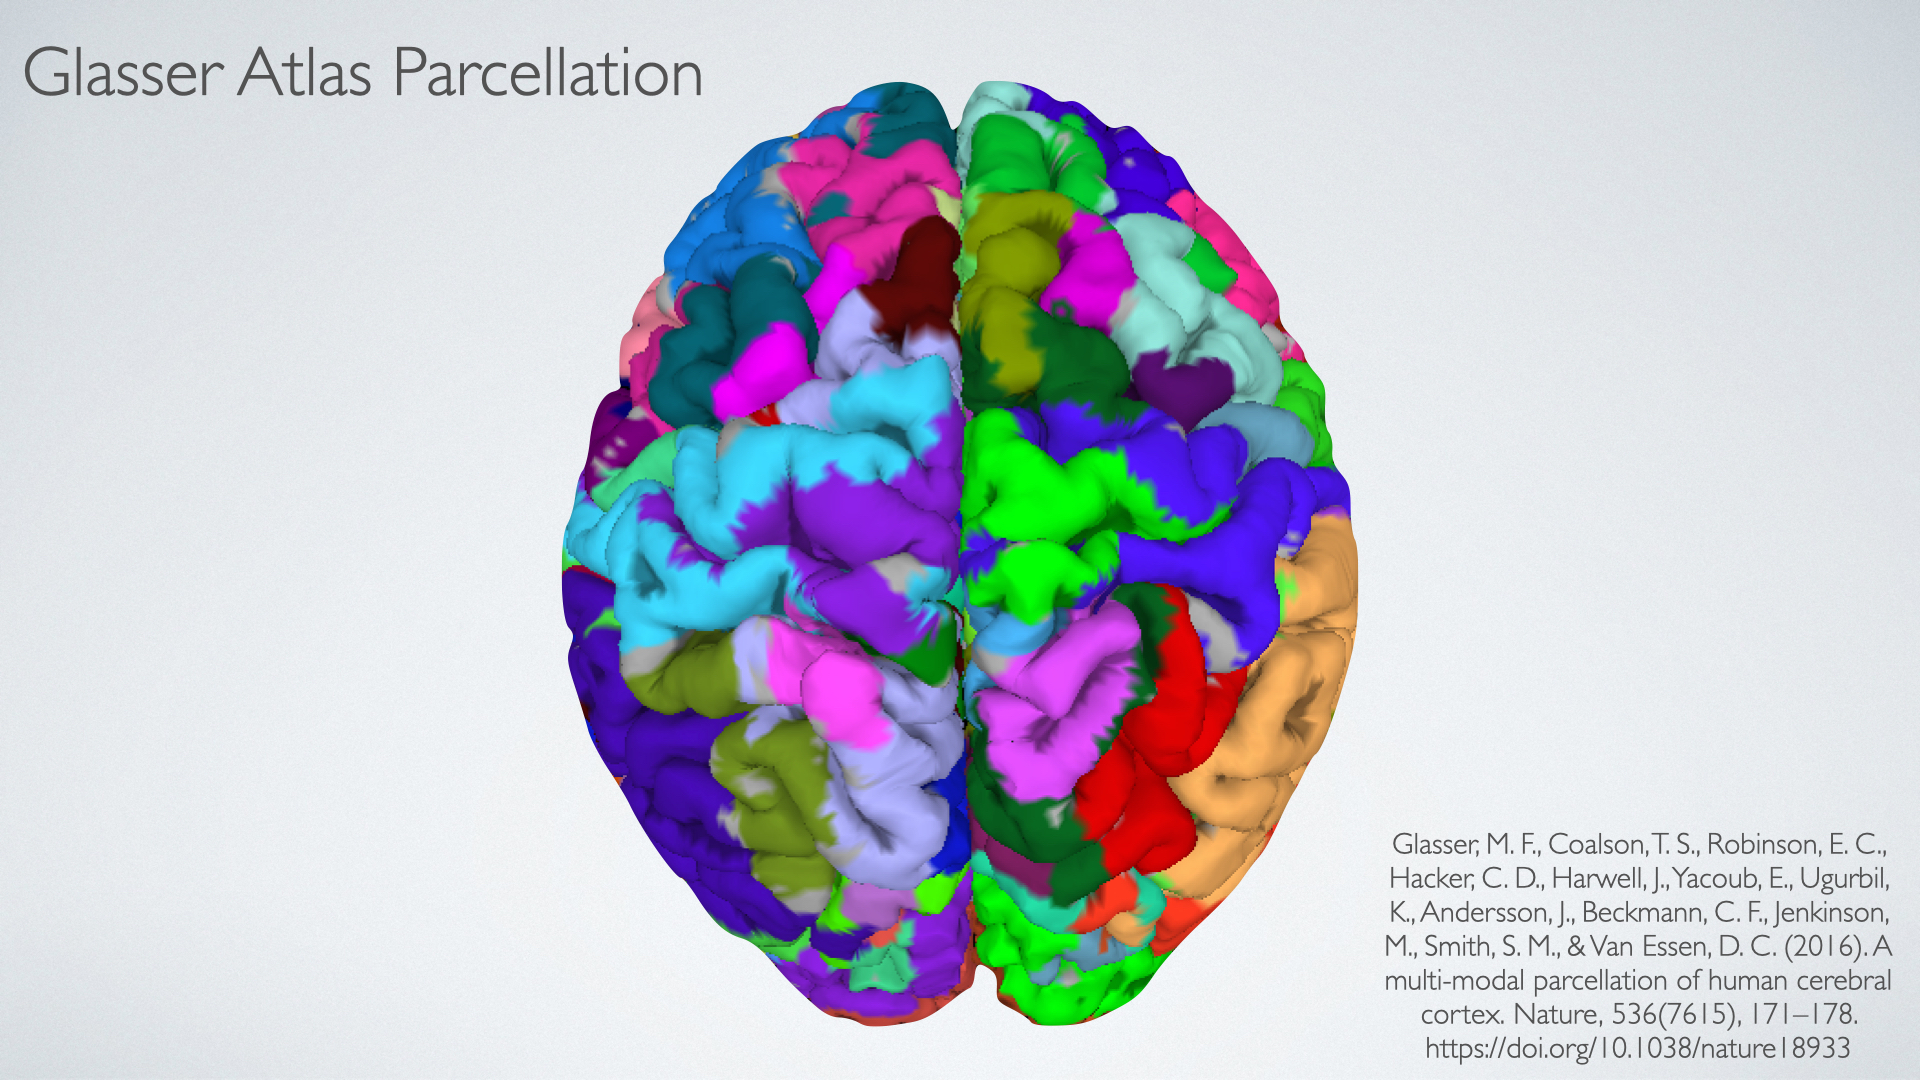

In [ ]:
%%R
home_dir = "/content/drive/MyDrive/Colab_Notebooks/final_project_files"

---
# 1. Average Node Activity

In [ ]:
# Utility Functions
%%R
get_upper_tri <- function(cormat){
  cormat[lower.tri(cormat, diag = FALSE)]<- NA
  return(cormat)
}
mean_cols <- function(dataframe) {
  apply(t(dataframe), 2, 
        function(x) mean(x))
}

### Load and Clean Up Data

In [ ]:
%%R 
# get average univariate activation of each node for each control
if (file.exists(paste0(home_dir,"/control_left_univar_upsmp.csv")) & file.exists(paste0(home_dir,"/control_rght_univar_upsmp.csv"))) {
    print('Since this data is already saved, you can load it from the csv\'s when you need them.')
} else {
  library(gdata)
  library(readr)
  library(ggplot2)
  library(tidyverse)
  library(patchwork)
  library(gtable)
  library(grid)
  library(gridExtra)
  library(reshape2)
  library(hrbrthemes)
  library(plot.matrix)
  library(zoo)
  library(stats)

  numTimePoints = 222-5
  subs = c(seq(1,28,1))
  for ( iSub in subs ) {
    if (iSub < 10) {
      iSub = paste0("0", toString(iSub))
    } else {
      iSub = toString(iSub)
    }
    filename = paste0(home_dir,"/ROI_Info_sub-", iSub, ".csv")
    ROI_Info_sub <- read_table2(filename, 
                                col_names = FALSE, 
                                locale = locale())
    
    if (dim(ROI_Info_sub)[2] != numTimePoints+5) {
      print('Error: input is not the expected size')
    }
    
    area_info = data.frame(ROI_Info_sub[seq(1,720,2),c(2,3,4,5)])
    colnames(area_info) <- c('side', 'area', 'run', 'voxels')

    #============================= Data Cleansing ===============================#
    # figure out which parcellations are missing
    parc_exist = area_info$area
    full_list = c(seq(1,180,1),
                  seq(1001,1180,1))
    parc_missing = full_list[!is.element(full_list, 
                                        parc_exist)]
    parc_present = full_list[is.element(full_list, 
                                        parc_exist)]
    parc_missing_360 = ifelse(parc_missing < 181, parc_missing, parc_missing-1000+180)
    parc_present_360 = ifelse(parc_present < 181, parc_present, parc_present-1000+180)
    parc_present_left = parc_present_360[parc_present_360 < 181]
    parc_present_rght = parc_present_360[parc_present_360 > 180]
    
    # extract just the time series data for Run 1, replace rows for nodes that don't exist with zero
    timecourse = data.frame(ROI_Info_sub[seq(1,dim(ROI_Info_sub)[1],2),6:(numTimePoints+5)])
    timecourse_full = data.frame(matrix(data=NA,nrow=360,ncol=dim(timecourse)[2]))
    
    counter = 0
    for (iNode in parc_present_360) {
      counter = counter + 1
      timecourse_full[iNode,] = timecourse[counter,]
    }
    
    TR = 3
    timecourse_left = timecourse_full[seq(1,180,1),]
    timecourse_rght = timecourse_full[seq(181,360,1),]
    timecourse_vals_orig = seq(1,numTimePoints*TR,TR)
    timecourse_vals_upsmp = timecourse_vals_orig / TR
    
    #================================= Z-score ==================================#
    z_timecourse_left <- na.omit(t(apply(timecourse_left, 1, function(x) (x - mean(x)) / sd(x))))
    z_timecourse_rght <- na.omit(t(apply(timecourse_rght, 1, function(x) (x - mean(x)) / sd(x))))

    #=============================== Resampling =================================#
    # upsample timecourses to 1 sec from 3 sec TRs to allow for comparison with patients
    z_timecourse_upsmp_left = t(apply(z_timecourse_left, 1,
                                  function(x) spline(timecourse_vals_upsmp, x,
                                                      n = length(timecourse_vals_upsmp) * TR + TR^2)$y))  
    
    z_timecourse_upsmp_rght = t(apply(z_timecourse_rght, 1,
                                      function(x) spline(timecourse_vals_upsmp, x,
                                                        n = length(timecourse_vals_upsmp) * TR + TR^2)$y))  
    
    z_timecourse_upsmp_left_full = data.frame(matrix(data=NA,nrow=180,ncol=dim(z_timecourse_upsmp_left)[2]))
    z_timecourse_upsmp_rght_full = data.frame(matrix(data=NA,nrow=180,ncol=dim(z_timecourse_upsmp_rght)[2]))
    
    countX = 0
    for (x in parc_present_left) {
      countX = countX + 1
      z_timecourse_upsmp_left_full[x,] = z_timecourse_upsmp_left[countX,]
    }
    countX = 0
    for (x in parc_present_rght) {
      countX = countX + 1
      z_timecourse_upsmp_rght_full[x-180,] = z_timecourse_upsmp_rght[countX,]
    }

    avg_upsmp_left = mean_cols(z_timecourse_upsmp_left_full)
    avg_upsmp_rght = mean_cols(z_timecourse_upsmp_rght_full)
    
  #================================ Saving ====================================#
    if ( iSub == "01" ) {
      group_avg_upsmp_left = avg_upsmp_left
      group_avg_upsmp_rght = avg_upsmp_rght
    } else {
      group_avg_upsmp_left = cbind(group_avg_upsmp_left,
                                  avg_upsmp_left)
      group_avg_upsmp_rght = cbind(group_avg_upsmp_rght,
                                  avg_upsmp_rght)
    }
  }

  df = data.frame(group_avg_upsmp_left)
  write.csv(df, paste0("control_left_univar_upsmp.csv"))
  df = data.frame(group_avg_upsmp_rght)
  write.csv(df, paste0("control_rght_univar_upsmp.csv"))
}

In [ ]:
%%R 
# get average univariate activation of each node for each patient (and two controls from the PRISMA scanner)
if (file.exists(paste0(home_dir,"/patient_univar_upsmp.csv"))) {
    print('Since this data is already saved, you can load it from the csv\'s when you need them.') 
} else {
    library(gdata)
    library(readr)
    library(ggplot2)
    library(tidyverse)
    library(patchwork)
    library(gtable)
    library(grid)
    library(gridExtra)
    library(reshape2)
    library(hrbrthemes)
    library(plot.matrix)
    library(zoo)
    library(stats)

    subs = c(7, 45, 78, 77, 83, 84)
    for ( iSub in subs ) {
      if (iSub < 10) {
        iSub = paste0("00", toString(iSub)) 
        side = 'right'
        TR = 2
      } else {
        if ( iSub == 77 ) {
          iSub = paste0("0", toString(iSub)) 
          side = "left"
          TR = 2
        } else {
          side = "right"
          iSub = paste0("0", toString(iSub)) 
          if ( iSub == "078" ) { 
            TR = 1.5 
          } else { 
            TR = 2 
          }
        }
      }
      
      filename = paste0("ROI_Info_sub-", iSub,".csv")
      ROI_Info_sub <- read_table2(filename, 
                                  col_names = FALSE, 
                                  locale = locale())
      area_info = data.frame(ROI_Info_sub[,c(2,3,4,5)])
      colnames(area_info) <- c('side', 'area', 'run', 'voxels')
      
      if ( TR == 1.5 ) {
        ROI_Info_sub = ROI_Info_sub[,16:dim(ROI_Info_sub)[2]]
      } else {
        if ( TR == 2 ) {
          ROI_Info_sub = ROI_Info_sub[,11:dim(ROI_Info_sub)[2]]
        }
      }
      
      numTimePoints = dim(ROI_Info_sub)[2]

      #============================= Data Cleansing ===============================#
      # check TR allocation 
      if ( !numTimePoints==(60*11.5/TR-(30/TR)) ) {
        print("TR assignment does not align with number of timepoints.")
        print(paste("TR was",numTimePoints,"and it should have been",toString(60*11.5/TR-10)))
      } 
      # figure out which parcellations are missing
      parc_exist = area_info$area
      full_list = c(seq(1,180,1),
                    seq(1001,1180,1))
      parc_missing = full_list[!is.element(full_list, 
                                          parc_exist)]
      parc_present = full_list[is.element(full_list, 
                                          parc_exist)]
      parc_missing_360 = ifelse(parc_missing < 181, parc_missing, parc_missing-1000+180)
      parc_present_360 = ifelse(parc_present < 181, parc_present, parc_present-1000+180)
      
      if ( side == 'left' ) { 
        parc_present_180 = parc_present_360[parc_present_360 < 181] 
      } else {
        parc_present_180 = parc_present_360[parc_present_360 > 180]
      }
      
      # extract just the time series data for Run 1, replace rows for nodes that don't exist with zero
      timecourse = data.frame(ROI_Info_sub[seq(1,dim(ROI_Info_sub)[1],2),])
      timecourse_full = data.frame(matrix(data=NA,nrow=360,ncol=dim(timecourse)[2]))
      
      counter = 0
      for (iNode in parc_present_360) {
        counter = counter + 1
        timecourse_full[iNode,] = timecourse[counter,]
      }
      
      if ( side == 'left' ) { 
        timecourse_side = timecourse_full[seq(1,180,1),] %>% drop_na() 
      } else {
        timecourse_side = timecourse_full[seq(181,360,1),] %>% drop_na()
      }
      
      timecourse_vals_orig = seq(1,numTimePoints*TR,TR)
      timecourse_vals_upsmp = timecourse_vals_orig / TR
      
    #================================= Z-score ==================================#
      # z-score each row
      z_timecourse <- na.omit(t(apply(timecourse_side, 1, function(x) (x - mean(x)) / sd(x))))

    #=============================== Resampling =================================#
      z_timecourse_upsmp = t(apply(z_timecourse, 1,
                            function(x) spline(timecourse_vals_upsmp, x,
                                                n = length(timecourse_vals_upsmp) * TR + TR^2)$y))  
      
      z_timecourse_upsmp_full = data.frame(matrix(data=NA,nrow=180,ncol=dim(z_timecourse_upsmp)[2]))
      
      countX = 0
      for (x in parc_present_180) {
        countX = countX + 1
        if ( side == 'right' ) {x = x-180}
        z_timecourse_upsmp_full[x,] = z_timecourse_upsmp[countX,]
      }
      
      avg_upsmp = mean_cols(z_timecourse_upsmp_full)
      
    #================================ Saving ===================================#
      if ( iSub == "007" ) {
        group_avg_upsmp = avg_upsmp
      } else {
        group_avg_upsmp = cbind(group_avg_upsmp,
                                avg_upsmp)
      }
    }

    df = data.frame(group_avg_upsmp)
    write.csv(df, paste0("patient_univar_upsmp.csv"))
}

[1] "Since this data is already saved, you can load it from the csv's when you need them."


### Visualization

In [ ]:
%%R

#============================= Required Packages ===============================#
if(!require("psycho")) suppressMessages(install.packages("psycho")); library(psycho)
if(!require("gridExtra")) suppressMessages(install.packages("gridExtra")); library(gridExtra)
if(!require("lmerTest")) suppressMessages(install.packages("lmerTest")); library(lmerTest)
if(!require("reshape2")) suppressMessages(install.packages("reshape2")); library(reshape2)
if(!require("ggpubr")) suppressMessages(install.packages("ggpubr")); library(ggpubr)
if(!require("broom.mixed")) suppressMessages(install.packages("broom.mixed")); library(broom.mixed)
if(!require("BayesFactor")) suppressMessages(install.packages("BayesFactor")); library(BayesFactor)

suppressMessages(library(ggplot2))
suppressMessages(library(RColorBrewer))
suppressMessages(library(readr))
suppressMessages(library(tidyverse))

myPalette <- colorRampPalette(rev(brewer.pal(5, "RdBu")))

In [ ]:
%%R
#================================ Load Data ===================================#
all_HCP = read.csv(paste0(home_dir,"/HCP_label_conversions.csv")) %>% 
  mutate(ID = ifelse(ID > 1000,  ID - 1000 + 180, ID)) %>%
  select(ID, group)

all_HCP_left = all_HCP %>% filter(ID < 181)
all_HCP_rght = all_HCP %>% filter(ID > 180) %>% mutate(ID = ID - 180)

filename = paste0(home_dir,"/control_left_univar_upsmp.csv")
ROI_avg_resp_L_upsmp <- read_csv(filename, col_names = TRUE, locale = locale(), col_types = cols())
ROI_avg_resp_L_upsmp = ROI_avg_resp_L_upsmp[,seq(2,28,1)]
filename = paste0(home_dir,"/control_rght_univar_upsmp.csv")
ROI_avg_resp_R_upsmp <- read_csv(filename, col_names = TRUE, locale = locale(), col_types = cols())
ROI_avg_resp_R_upsmp = ROI_avg_resp_R_upsmp[,seq(2,28,1)]

filename = paste0(home_dir,"/patient_univar_upsmp.csv")
ptnt_avg_resp_upsmp <- read_csv(filename, col_names = TRUE, locale = locale(), col_types = cols())
ptnt_avg_resp_upsmp = ptnt_avg_resp_upsmp[,c(2,3,4,5)]

In [ ]:
%%R
#================= Combine Patient with Matched Control Data ==================#
# order of patients = c(7, 45, 78, 77)

cntrls_007 = cbind(ROI_avg_resp_R_upsmp[all_HCP_rght$ID,c(15,11,19,23,20,21,26,27,25,22)],
                   ptnt_avg_resp_upsmp[all_HCP_rght$ID,1])
cntrls_045 = cbind(ROI_avg_resp_R_upsmp[all_HCP_rght$ID,c(12,16,10,14,17,18,15,11)],
                   ptnt_avg_resp_upsmp[all_HCP_rght$ID,2])
cntrls_077 = cbind(ROI_avg_resp_L_upsmp[all_HCP_left$ID,c(2,6,5,9,4,7,8,3,1)],
                   ptnt_avg_resp_upsmp[all_HCP_left$ID,4])
cntrls_078 = cbind(ROI_avg_resp_R_upsmp[all_HCP_rght$ID,c(15,11,19,23,20,21,26,27,25,22)],
                   ptnt_avg_resp_upsmp[all_HCP_rght$ID,3])

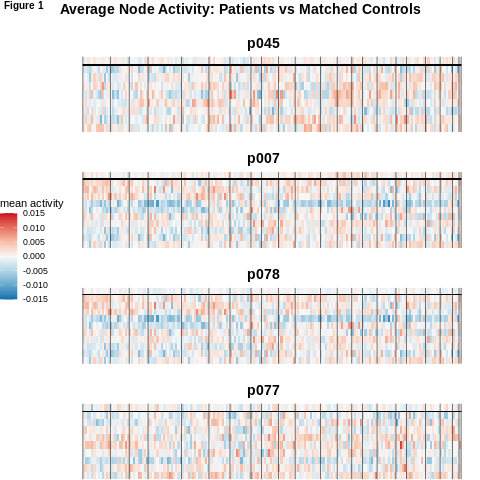

In [ ]:
%%R
#================= Visualize Patient and Matched Control Data ==================#
# Create the borders for the plot demarcating the 22 functional groups
bounds = rev(c(0,1,4,10,17,26,31,40,47,52,59,67,79,87,95,100,110,120,133,149,158,167,180)+0.5)
bounds1 = c(0,bounds)
bounds2 = c(bounds,0)
bounds_diff = bounds1-bounds2
bounds_diff = c(0,rev(bounds_diff[2:23]))
for (i in seq(1,23)) {
  if (i == 1) {
    val = 180-bounds_diff[i]
    new_bounds = val
  } else {
      val = val-bounds_diff[i]
      new_bounds = rbind(new_bounds, val)
  } 
}
bounds_df = data.frame(bound = new_bounds + 0.5)

uni_mat = cntrls_045
p045 = ggplot(data = melt(uni_mat, id.vars = NULL) %>% mutate(parcel = rep(1:180,dim(uni_mat)[2])),
            aes(y = variable,
                x = parcel)) + 
        geom_tile(aes(fill = value)) +
        geom_segment(data=bounds_df,
                    aes(y = 0.5, x = bound, yend=dim(uni_mat)[2]-0.5, xend=bound),
                    size = 0.25,
                    inherit.aes = FALSE) +
        geom_segment(data=bounds_df,
                    aes(y = dim(uni_mat)[2]-1.5, x = 0.5, yend=dim(uni_mat)[2]-1.505, xend=180.5),
                    size = 0.2,
                    inherit.aes = FALSE) +
        theme_void() + 
        scale_fill_gradientn(name = 'mean activity', colours = myPalette(7), limits=c(-0.015,0.015)) 

uni_mat = cntrls_007
p007 = ggplot(data = melt(uni_mat, id.vars = NULL) %>% mutate(parcel = rep(1:180,dim(uni_mat)[2])),
            aes(y = variable, x = parcel)) + 
        geom_tile(aes(fill = value)) +
        geom_segment(data=bounds_df,
                    aes(y = 0.5, x = bound, yend=dim(uni_mat)[2]+1.5, xend=bound),
                    size = 0.25, inherit.aes = FALSE) +
        geom_segment(data=bounds_df,
                    aes(y = dim(uni_mat)[2]+0.5, x = 0.5, yend=dim(uni_mat)[2]+0.505, xend=180.5),
                    size = 0.2, inherit.aes = FALSE) +
        theme_void() + 
        scale_fill_gradientn(name = 'mean activity', colours = myPalette(7), limits=c(-0.015,0.015)) 

uni_mat = cntrls_078
p078 = ggplot(data = melt(uni_mat, id.vars = NULL) %>% mutate(parcel = rep(1:180,dim(uni_mat)[2])),
            aes(y = variable, x = parcel)) + 
        geom_tile(aes(fill = value)) +
        geom_segment(data=bounds_df,
                    aes(y = 0.5, x = bound, yend=dim(uni_mat)[2]+1.5, xend=bound),
                    size = 0.25, inherit.aes = FALSE) +
        geom_segment(data=bounds_df,
                    aes(y = dim(uni_mat)[2]+0.5, x = 0.5, yend=dim(uni_mat)[2]+0.505, xend=180.5),
                    size = 0.2, inherit.aes = FALSE) +
        theme_void() + 
        scale_fill_gradientn(name = 'mean activity', colours = myPalette(7), limits=c(-0.015,0.015)) 

uni_mat = cntrls_077
p077 = ggplot(data = melt(uni_mat, id.vars = NULL) %>% mutate(parcel = rep(1:180,dim(uni_mat)[2])),
            aes(y = variable, x = parcel)) + 
        geom_tile(aes(fill = value)) +
        geom_segment(data=bounds_df,
                    aes(y = 0.5, x = bound, yend=dim(uni_mat)[2]+0.5, xend=bound),
                    size = 0.25, inherit.aes = FALSE) +
        geom_segment(data=bounds_df,
                    aes(y = dim(uni_mat)[2]-0.5, x = 0.5, yend=dim(uni_mat)[2]-0.505, xend=180.5),
                    size = 0.2, inherit.aes = FALSE) +
        theme_void() + 
        scale_fill_gradientn(name = 'mean activity', colours = myPalette(7), limits=c(-0.015,0.015))

figure1 <- ggarrange(ggparagraph(text=" ", color = "white"), p045, 
                     ggparagraph(text=" ", color = "white"), p007, 
                     ggparagraph(text=" ", color = "white"), p078, 
                     ggparagraph(text=" ", color = "white"), p077,
                     labels = c(" ", "p045", " ", "p007", " ", "p078", " ", "p077"),
                     ncol = 1, nrow = 8,
                     common.legend = TRUE,
                     heights = c(0.5,1,0.5,1,0.5,1,0.5,1),
                     legend = "left",
                     label.x = 0.4,
                     label.y = 1.3)

annotate_figure(figure1,
               top = text_grob("Average Node Activity: Patients vs Matched Controls", color = "black", face = "bold", size = 14),
              #  bottom = text_grob("Data source: \n ToothGrowth data set", color = "blue",
              #                     hjust = 1, x = 1, face = "italic", size = 10),
              #  left = text_grob("Figure arranged using ggpubr", color = "green", rot = 90),
              #  right = text_grob(bquote("Superscript: ("*kg~NH[3]~ha^-1~yr^-1*")"), rot = 90),
               fig.lab = "Figure 1", fig.lab.face = "bold", fig.lab.size = 10)


### Analyses

In [ ]:
%%R
#=========================== Analysis Functions ===============================#
ctest.pval <- function(patient, ctrl_mean, ctrl_sd, n) {
  results = crawford.test(patient = patient,
                          mean = ctrl_mean,
                          sd = ctrl_sd,
                          n = n,
                          CI = 95, 
                          treshold = 0.1,
                           iter = 10000,
                          color_controls = "#2196F3",
                          color_CI = "#E91E63",
                          color_score = "black",
                          color_size = 2,
                          alpha_controls = 1,
                          alpha_CI = 0.8)
  p_val = as.numeric(summary(results)[4])
  return(p_val)}

run.ctest <- function(long_table, n) {
  crawf.p = data.frame(p_val = matrix(data=NA,nrow=dim(long_table)[1],ncol=1))
  for (iRow in 1:dim(long_table)[1]) {
    if ( !is.na(long_table[iRow,ncol(long_table)]) ) {
      crawf.p[iRow,1] = ctest.pval(as.numeric(long_table[iRow,ncol(long_table)]),
                                   mean(as.numeric(long_table[iRow,-1])),
                                   sd(as.numeric(long_table[iRow,-1])),
                                   n)
    }
  }
  return(crawf.p)}

FDR.correct <- function(p_vals){
  adj_p = p.adjust(p_vals$p_val, method = "fdr", n = length(p_vals$p_val))
  return(adj_p)}

#### Permutation Test

In [ ]:
%%R
#============ Permutation Test of Patient with Matched Controls ================#

up_pvals_078 = run.ctest(cntrls_078, 10) %>% na.omit() %>% FDR.correct() 
print(paste('Patient 78 has',sum(up_pvals_078 < 0.05),'nodes that are significantly different from their controls.'))
up_pvals_077 = run.ctest(cntrls_077, 9) %>% na.omit() %>% FDR.correct()
print(paste('Patient 77 has',sum(up_pvals_078 < 0.05),'nodes that are significantly different from their controls.'))
up_pvals_007 = run.ctest(cntrls_007, 10) %>% na.omit() %>% FDR.correct()
print(paste('Patient 7 has',sum(up_pvals_078 < 0.05),'nodes that are significantly different from their controls.'))
up_pvals_045 = run.ctest(cntrls_045, 8) %>% na.omit() %>% FDR.correct()
print(paste('Patient 45 has',sum(up_pvals_078 < 0.05),'nodes that are significantly different from their controls.'))


[1] "Patient 78 has 0 nodes that are significantly different from their controls."
[1] "Patient 77 has 0 nodes that are significantly different from their controls."
[1] "Patient 7 has 0 nodes that are significantly different from their controls."
[1] "Patient 45 has 0 nodes that are significantly different from their controls."


#### Linear Mixed Effects Model

In [ ]:
%%R

#============================  Restructure Data  ==============================#
restructure_data <- function(uni_mat) {
  colnames(uni_mat) = c(seq(1,dim(uni_mat)[2]-1,1),'ptnt')
  ctrl_vs_ptnt = melt(uni_mat, id.vars = NULL) %>% 
    mutate(parcel = rep(1:180,dim(uni_mat)[2]),
          group  = ifelse(variable != 'ptnt', 'ctrl','ptnt')) %>%
    rename(subjID = variable, avg_resp = value) %>%
    mutate(subjID = factor(subjID))
return(ctrl_vs_ptnt)
}

ctrl_vs_ptnt045 = restructure_data(cntrls_045)
ctrl_vs_ptnt007 = restructure_data(cntrls_007)
ctrl_vs_ptnt078 = restructure_data(cntrls_078)
ctrl_vs_ptnt077 = restructure_data(cntrls_077)

In [ ]:
%%R
#========== Linear Mixed Effects Model Patient vs Matched Controls ============#

#===============================  Run GLM  ====================================#
glm.fit045 = lmer(avg_resp ~ group * parcel + (1|subjID), data = ctrl_vs_ptnt045)
glm.fit007 = lmer(avg_resp ~ group * parcel + (1|subjID), data = ctrl_vs_ptnt007)
glm.fit078 = lmer(avg_resp ~ group * parcel + (1|subjID), data = ctrl_vs_ptnt078)
glm.fit077 = lmer(avg_resp ~ group * parcel + (1|subjID), data = ctrl_vs_ptnt077)

p045.summ = summary(glm.fit045) 
p077.summ = summary(glm.fit077) 
p078.summ = summary(glm.fit078) 
p007.summ = summary(glm.fit007) 

#### Bayes Factor Calculation

In [ ]:
%%R

df = ctrl_vs_ptnt077
full_BF = lmBF(avg_resp ~ group * parcel + subjID, data = df, whichRandom = 'subjID', progress = FALSE)
full_no_interaction_BF = lmBF(avg_resp ~ group + parcel + subjID, data = df, whichRandom = 'subjID', progress = FALSE)
parcel_only_BF = lmBF(avg_resp ~ parcel + subjID, data = df, whichRandom = 'subjID', progress = FALSE)
group_only_BF = lmBF(avg_resp ~ group + subjID, data = df, whichRandom = 'subjID', progress = FALSE)


In [ ]:
%%R
allBFs <- c(full_BF, full_no_interaction_BF, parcel_only_BF, group_only_BF)
allBFs

Bayes factor analysis
--------------
[1] group * parcel + subjID : 6.389416e+25 ±1.18%
[2] group + parcel + subjID : 7.918147e+26 ±4.09%
[3] parcel + subjID         : 1.789873e+27 ±1.29%
[4] group + subjID          : 8.606486e+27 ±1.03%

Against denominator:
  Intercept only 
---
Bayes factor type: BFlinearModel, JZS



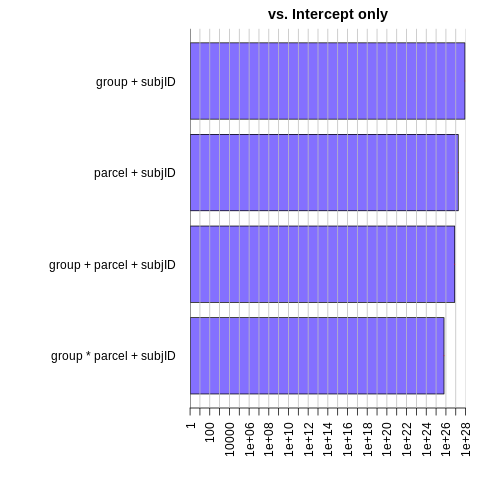

In [ ]:
%%R
plot(allBFs)

In [ ]:
%%R
full_BF/full_no_interaction_BF

Bayes factor analysis
--------------
[1] group * parcel + subjID : 0.08069332 ±4.25%

Against denominator:
  avg_resp ~ group + parcel + subjID 
---
Bayes factor type: BFlinearModel, JZS



### Interpretation and Conclusion

---
# 2. Edge Connectivity

In [ ]:
%%R
if(!require("data.table")) suppressMessages(install.packages("data.table")); library(data.table)

In [ ]:
%%R
get.ctrl.RSS_corr.data <- function() {  
  if(!require("readr")) install.packages("readr"); library(readr)
  if(!require("stats")) install.packages("stats"); library(stats)

  numTimePoints = 222-5
  subs = c(seq(1,28,1))
  for ( iSub in subs ) {
    if (iSub < 10) {
      iSub = paste0("0", toString(iSub))
    } else {
      iSub = toString(iSub)
    }
    filename = paste0(home_dir, "/ROI_Info_sub-", iSub, ".csv")
    ROI_Info_sub <- read_table2(filename, 
                                col_names = FALSE, 
                                locale = locale())
    
    if (dim(ROI_Info_sub)[2] != numTimePoints+5) {
      print('Error: input is not the expected size')
    }
    
    area_info = data.frame(ROI_Info_sub[seq(1,720,2),c(2,3,4,5)])
    colnames(area_info) <- c('side', 'area', 'run', 'voxels')
    
    # figure out which parcellations are missing
    parc_exist = area_info$area
    full_list = c(seq(1,180,1),
                  seq(1001,1180,1))
    parc_missing = full_list[!is.element(full_list, 
                                         parc_exist)]
    parc_present = full_list[is.element(full_list, 
                                        parc_exist)]
    parc_missing_360 = ifelse(parc_missing < 181, parc_missing, parc_missing-1000+180)
    parc_present_360 = ifelse(parc_present < 181, parc_present, parc_present-1000+180)
    
    # extract just the time series data for Run 1, replace rows for nodes that don't exist with zero
    timecourse = data.frame(ROI_Info_sub[seq(1,dim(ROI_Info_sub)[1],2),6:(numTimePoints+5)])
    timecourse_full = data.frame(matrix(data=NA,nrow=360,ncol=dim(timecourse)[2]))
    
    counter = 0
    for (iNode in parc_present_360) {
      counter = counter + 1
      timecourse_full[iNode,] = timecourse[counter,]
    }
    
    TR = 3
    timecourse_vals_orig = seq(1,numTimePoints*TR,TR)
    timecourse_vals_upsmp = timecourse_vals_orig / TR

    # z-score each row
    z_timecourse_x <- t(apply(timecourse_full, 1, function(x) (x - mean(x)) / sd(x)))
    z_timecourse_x = na.omit(z_timecourse_x)
    z_timecourse_y <- t(apply(timecourse_full, 1, function(x) (x - mean(x)) / sd(x)))
    z_timecourse_y = t(na.omit(z_timecourse_y))
    z_timecourse_x_upsmp = t(apply(z_timecourse_x, 1,
                                   function(x) spline(timecourse_vals_upsmp, x,
                                                      n = length(timecourse_vals_upsmp) * TR + TR^2)$y))  
    z_timecourse_y_upsmp = apply(z_timecourse_y, 2, 
                                 function(x) spline(timecourse_vals_upsmp, x,
                                                    n = length(timecourse_vals_upsmp) * TR + TR^2)$y)
    

    cols = c(seq(1,360 - length(parc_missing),1)) 
    for (col in cols) {
      if(col == 1) {
        single_corr_upsmp <- t(apply(z_timecourse_x_upsmp, 1, 
                                     function(x) cor(x,
                                                     z_timecourse_y_upsmp[,col],
                                                     method=c("pearson"))))
      } else {
        single_corr_upsmp <- rbind(single_corr_upsmp,
                                   next_corr <- t(apply(z_timecourse_x_upsmp, 1, 
                                                        function(x) cor(x,
                                                                        z_timecourse_y_upsmp[,col],
                                                                        method=c("pearson")))))
      }
    }

    #=============================Correlation Part===================================#
    # put the NA back
    single_corr_upsmp_full = data.frame(matrix(data=NA,nrow=360,ncol=360))
    
    countX = 0
    for (x in parc_present_360) {
      countX = countX + 1
      countY = 0
      for (y in parc_present_360) {
        countY = countY + 1
        single_corr_upsmp_full[x,y] = single_corr_upsmp[countX,countY]
      }
    }
    
    # get corr matrix, remove diagonal (self correlations of 1)
    corr_raw_timecourse360_upsmp = single_corr_upsmp_full %>% 
      as.matrix() %>%
      get_upper_tri() %>% 
      melt() %>% 
      mutate(Var2 = readr::parse_number(toString(Var2)),
             subjID = iSub)

    #=============================Saving Part===================================#
    if ( iSub == "01" ) {
      raw_timecourse_long_corr_upsmp = corr_raw_timecourse360_upsmp      
    } else {

      raw_timecourse_long_corr_upsmp = rbind(raw_timecourse_long_corr_upsmp,
                                             corr_raw_timecourse360_upsmp)
    }  
  }
  df = data.frame(raw_timecourse_long_corr_upsmp)
  write.csv(df, paste0(home_dir, "/all_control_upsmp_corr.csv"))}

get.ptnt.RSS_corr.data <- function(iSub, side, TR) {

  if(!require("readr")) install.packages("readr"); library(readr)
  if(!require("stats")) install.packages("stats"); library(stats)
  
  get_upper_tri <- function(cormat){
    cormat[lower.tri(cormat, diag = TRUE)]<- NA
    return(cormat)
  }
  if (iSub < 10) {
    filename = paste0("ROI_Info_sub-00", iSub,".csv")
  } else{
    filename = paste0("ROI_Info_sub-0", iSub,".csv")
  }
  
  ROI_Info_sub <- read_table2(filename, 
                              col_names = FALSE, 
                              locale = locale())
  
  
  area_info = data.frame(ROI_Info_sub[,c(2,3,4,5)])
  colnames(area_info) <- c('side', 'area', 'run', 'voxels')
  
  numTimePoints = dim(ROI_Info_sub)[2]-5
  # check TR allocation 
  if ( !numTimePoints==(60*11.5/TR-10) ) {
    print("TR assignment does not align with number of timepoints.")
  } 
  
  if ( TR == 1.5 ) {
    ROI_Info_sub = ROI_Info_sub[,16:dim(ROI_Info_sub)[2]-5]
    numTimePoints = dim(ROI_Info_sub)[2]
  } else {
    if ( TR == 2 ) {
      ROI_Info_sub = ROI_Info_sub[,11:dim(ROI_Info_sub)[2]-5]
      numTimePoints = dim(ROI_Info_sub)[2]
    }
  }
  
  parc_exist = area_info$area
  full_list = c(seq(1,180,1),
                seq(1001,1180,1))
  parc_missing = full_list[!is.element(full_list, 
                                       parc_exist)]
  parc_present = full_list[is.element(full_list, 
                                      parc_exist)]

  parc_missing_360 = ifelse(parc_missing < 181, parc_missing, parc_missing-1000+180)
  parc_present_360 = ifelse(parc_present < 181, parc_present, parc_present-1000+180)
  
  # extract just the time series data for Run 1, replace rows for nodes that don't exist with zero
  timecourse = data.frame(ROI_Info_sub[seq(1,dim(ROI_Info_sub)[1],2),])
  timecourse_full = data.frame(matrix(data=NA,nrow=360,ncol=dim(timecourse)[2]))
  
  counter = 0
  for (iNode in parc_present_360) {
    counter = counter + 1
    timecourse_full[iNode,] = timecourse[counter,]
  }
  
  timecourse_vals_orig = seq(1,numTimePoints*TR,TR)
  timecourse_vals_upsmp = timecourse_vals_orig / TR

  #=============================== Resampling ================================#

  if ( side == "left" ) {
    timecourse_left = timecourse_full[seq(1,180,1),] %>% drop_na()
    z_timecourse_x_left <- t(apply(timecourse_left, 1, function(x) (as.numeric(x) - mean(as.numeric(x)) / sd(as.numeric(x)))))
    z_timecourse_y_left <- apply(timecourse_left, 1, function(x) (as.numeric(x) - mean(as.numeric(x))) / sd(as.numeric(x)))
    z_timecourse_x_left_upsmp = t(apply(z_timecourse_x_left, 
                                        1, 
                                        function(x) spline(timecourse_vals_upsmp, x,
                                                           n = length(timecourse_vals_upsmp) * TR)$y))
    z_timecourse_y_left_upsmp = apply(z_timecourse_y_left, 
                                        2, 
                                        function(x) spline(timecourse_vals_upsmp, x,
                                                           n = length(timecourse_vals_upsmp) * TR)$y)
  } else {
    timecourse_rght = timecourse_full[seq(181,360,1),] %>% drop_na()
    z_timecourse_x_rght <- t(apply(timecourse_rght, 1, function(x) (as.numeric(x) - mean(as.numeric(x))) / sd(as.numeric(x))))
    z_timecourse_y_rght <- apply(timecourse_rght, 1, function(x) (as.numeric(x) - mean(as.numeric(x))) / sd(as.numeric(x)))
    z_timecourse_x_rght_upsmp = t(apply(z_timecourse_x_rght, 
                                        1, 
                                        function(x) spline(timecourse_vals_upsmp, x,
                                                           n = length(timecourse_vals_upsmp) * TR)$y))
    z_timecourse_y_rght_upsmp = apply(z_timecourse_y_rght, 
                                      2, 
                                      function(x) spline(timecourse_vals_upsmp, x,
                                                         n = length(timecourse_vals_upsmp) * TR)$y)
  }

  #=============================== Correlation ================================#
  cols180 = c(seq(1,180,1))
  for (col in cols180) {
    if(col == 1) {
      if(side == 'left') {
        single_corr_upsmp <- t(apply(z_timecourse_x_left_upsmp, 1, 
                                     function(x) cor(x,
                                                     z_timecourse_y_left_upsmp[,col],
                                                     method=c("pearson"))))
      } else {
        single_corr_upsmp <- t(apply(z_timecourse_x_rght_upsmp, 1, 
                                     function(x) cor(x,
                                                     z_timecourse_y_rght_upsmp[,col],
                                                     method=c("pearson"))))
      }
    } else {
      if(side == 'left') {
        single_corr_upsmp = rbind(single_corr_upsmp,
                                  next_corr <- t(apply(z_timecourse_x_left_upsmp, 1, 
                                                       function(x) cor(x,
                                                                       z_timecourse_y_left_upsmp[,col],
                                                                       method=c("pearson")))))
      } else {
          single_corr_upsmp = rbind(single_corr_upsmp,
                                    next_corr <- t(apply(z_timecourse_x_rght_upsmp, 1, 
                                                         function(x) cor(x,
                                                                         z_timecourse_y_rght_upsmp[,col],
                                                                         method=c("pearson")))))
      }
    }
  }
  

  # put the NA back
  single_corr_upsmp_full = data.frame(matrix(data=NA,nrow=180,ncol=180))
  
  if ( side == 'left' ) {
    parc_present_side = parc_present_360[parc_present_360<181]
  } else{
    parc_present_side = parc_present_360[parc_present_360>180]
  }
  
  parc_present_180 = ifelse(parc_present_side < 181, 
                            parc_present_side, 
                            parc_present_side-180)
  
  countX = 0
  for (x in parc_present_180) {
    countX = countX + 1
    countY = 0
    for (y in parc_present_180) {
      countY = countY + 1
      single_corr_upsmp_full[x,y] = single_corr_upsmp[countX,countY]
    }
  }
  # get corr matrix, remove diagonal (self correlations of 1) 

  corr_raw_timecourse180_upsmp = single_corr_upsmp_full %>% 
    as.matrix() %>%
    get_upper_tri() %>%
    melt() %>%
    mutate(Var2 = readr::parse_number(toString(Var2)),
           subjID = iSub)

  #================================= Saving ===================================#
  
  
  if ( side == "left" ) {
    df = data.frame(corr_raw_timecourse180_upsmp)
    write.csv(df, paste0(home_dir,"/all_corr_sub-0",iSub,"_left_upsmp_corr.csv"))
  } else {
    df = data.frame(corr_raw_timecourse180_upsmp)
    write.csv(df, paste0(home_dir,"/all_corr_sub-0",iSub,"_rght_upsmp_corr.csv"))
  }}

if (file.exists(paste0(home_dir, "/all_control_upsmp_corr.csv"))) {
    print('This one takes an especially long time. Let\'s load the data instead.')
} else {
    get.ctrl.RSS_corr.data()
}

subs = c('07','045','078','077','083','083','084','084')
sides = c('rght','rght','rght','left','left','rght','left','rght')
TRs = c(2,2,1.5,2,1.5,1.5,1.5,1.5)

for (iPtnt in seq(1,length(subs),1)) {
  if (file.exists(paste0(home_dir, "/all_corr_sub-",subs[iPtnt],"_",sides[iPtnt],"_upsmp_corr.csv"))) {
      print('This one takes an especially long time. Let\'s load the data instead.')
  } else {
      get.ptnt.RSS_corr.data(iSub = readr::parse_number(subs[iPtnt]), side = sides[iPtnt], TR = TRs[iPtnt])
  }
}

In [ ]:
%%R

edge_corr_cntrls = fread(paste0(home_dir,"/all_control_upsmp_corr.csv"))
head(edge_corr_cntrls %>% mutate(row = factor(row), subjID = factor(subjID)))

   row Var1 Var2 value subjID
1: '1'    1    1     1   '01'
2: '2'    2    1    NA   '01'
3: '3'    3    1    NA   '01'
4: '4'    4    1    NA   '01'
5: '5'    5    1    NA   '01'
6: '6'    6    1    NA   '01'


In [ ]:
%%R

# load scheme for sorting parcellations into HCP functional groups
all_HCP = read.csv(paste0(home_dir,"/HCP_label_conversions.csv")) %>% 
  mutate(ID = ifelse(ID > 1000,  ID - 1000 + 180, ID)) %>%
  select(ID, group)

# load control edge correlation data and remove subject 13
edge_corr_cntrls = fread(paste0(home_dir,"/all_control_upsmp_corr.csv")) %>%
  mutate(subjID = readr::parse_number(subjID)) %>%
  filter(subjID != 13) %>%
  nest_join(., all_HCP, by = c("Var1" = "ID"), name = "Var1Group") %>%
  nest_join(., all_HCP, by = c("Var2" = "ID"), name = "Var2Group") %>%
  mutate(Var1Group = unlist(Var1Group),
         Var2Group = unlist(Var2Group),
         edgeGroup = ifelse(Var1Group==Var2Group, "withinGroup", "btwnGroup"),
         Var1Side = ifelse(Var1 < 181, "left", "right"),
         Var2Side = ifelse(Var2 < 181, "left", "right"),
         edgeSide = ifelse(Var1Side == Var2Side, Var1Side, "cross"),
         Var1Group = ifelse(Var1Group < Var2Group, Var1Group, Var2Group),
         Var2Group = ifelse(Var1Group < Var2Group, Var2Group, Var1Group)) %>%
  rename(corr = value)

avg_left_edge_corr_cntrls = edge_corr_cntrls %>% 
  filter(edgeSide == 'left', Var1Side == 'left') %>%
  group_by(Var1, Var2, subjID) %>%
  summarise(group_corr = mean(corr, na.rm = TRUE),
            group_sd = sd(corr, na.rm = TRUE),
            .groups = 'drop')

avg_rght_edge_corr_cntrls = edge_corr_cntrls %>%
  filter(edgeSide == 'right', Var1Side == 'right') %>%
  group_by(Var1, Var2, subjID) %>%
  summarise(group_corr = mean(corr, na.rm = TRUE),
            group_sd = sd(corr, na.rm = TRUE),
            .groups = 'drop') 

In [ ]:
%%R
head(avg_rght_edge_corr_cntrls)

# A tibble: 6 x 5
   Var1  Var2 subjID group_corr group_sd
  <dbl> <dbl>  <dbl>      <dbl>    <dbl>
1   181   181      1          1       NA
2   181   181      2          1       NA
3   181   181      3          1       NA
4   181   181      4          1       NA
5   181   181      5          1       NA
6   181   181      6          1       NA


In [ ]:
%%R

load_edge_corr <- function(filename, side, subID) {
  if (side == 'left') {
      idx = 0
  } else {
      idx = 180
  }
  edge_corr_data = read.csv(paste0(home_dir,filename)) %>%
    mutate(Var1 = Var1+idx,
          Var2 = Var2+idx) %>%
    nest_join(., all_HCP, by = c("Var1" = "ID"), name = "Var1Group") %>%
    nest_join(., all_HCP, by = c("Var2" = "ID"), name = "Var2Group") %>%
    mutate(Var1Group = unlist(Var1Group),
          Var2Group = unlist(Var2Group),
          edgeGroup = ifelse(Var1Group==Var2Group, "withinGroup", "btwnGroup"),
          edgeSide = side,
          Var1Group = ifelse(Var1Group < Var2Group, Var1Group, Var2Group),
          Var2Group = ifelse(Var1Group > Var2Group, Var1Group, Var2Group),
          subjID = subID) %>%
    rename(corr = value) %>%
    group_by(Var1, Var2, subjID) %>%
    summarise(group_corr = mean(corr),
              group_sd = sd(corr),
              .groups = 'drop')
  return(edge_corr_data)
}

# load patient edge correlation data
edge_corr_pat107_rght = load_edge_corr("/all_corr_sub-07_rght_upsmp_corr.csv",  'right', 107)
edge_corr_pat045_rght = load_edge_corr("/all_corr_sub-045_rght_upsmp_corr.csv", 'right', 45)
edge_corr_pat078_rght = load_edge_corr("/all_corr_sub-078_rght_upsmp_corr.csv", 'right', 78)
edge_corr_pat077_left = load_edge_corr("/all_corr_sub-077_left_upsmp_corr.csv", 'left',  77)
edge_corr_ctl083_left = load_edge_corr("/all_corr_sub-083_left_upsmp_corr.csv", 'left',  83)
edge_corr_ctl083_rght = load_edge_corr("/all_corr_sub-083_rght_upsmp_corr.csv", 'right', 83)
edge_corr_ctl084_left = load_edge_corr("/all_corr_sub-084_left_upsmp_corr.csv", 'left',  84)
edge_corr_ctl084_rght = load_edge_corr("/all_corr_sub-084_rght_upsmp_corr.csv", 'right', 84)


load_pat_edge_corr <- function(side, pat_data, subList) {
    if (side == 'left') {control_data = avg_left_edge_corr_cntrls} else {control_data = avg_rght_edge_corr_cntrls}
    edge_pat_corr_data = control_data %>%
      filter(subjID %in% subList) %>%
      group_by(Var1, Var2) %>%
      summarise(ctrl_mean = mean(group_corr, na.rm = TRUE),
                ctrl_sd = sd(group_corr, na.rm = TRUE),
                .groups = 'drop') %>%
      inner_join(., pat_data,
                by = c("Var1" = "Var1",
                        "Var2" = "Var2")) %>%
      rename(ptnt_corr = group_corr,
            ptnt_sd = group_sd) %>%
      mutate(out2SD = ifelse(abs(ptnt_corr) > (abs(ctrl_mean)+2*ctrl_sd), 1, 0),
            dir2SD = ifelse((out2SD == 1 & (ptnt_corr > ctrl_mean)), ptnt_corr, 
                            ifelse((out2SD == 1 & (ptnt_corr < ctrl_mean)), ptnt_corr, NA)))%>%
      replace_na(list(ctrl_mean = 0, ctrl_sd = 0, corr_neg = 0, out2SD = 0))
      return(edge_pat_corr_data)
}

rght_107 = load_pat_edge_corr('right', edge_corr_pat107_rght, c(11,15,19,27,23,25,22,20,21,26))
rght_045 = load_pat_edge_corr('right', edge_corr_pat045_rght, c(12,16,10,14,17,18,15,11))
rght_078 = load_pat_edge_corr('right', edge_corr_pat078_rght, c(11,15,19,27,23,25,22,20,21,26))
left_077 = load_pat_edge_corr('left', edge_corr_pat077_left, c(2,6,5,9,4,7,8,3,1))
left_083 = load_pat_edge_corr('left', edge_corr_ctl083_left, c(8,3,1,12,16,10,14,17,18))
rght_083 = load_pat_edge_corr('right', edge_corr_ctl083_rght, c(8,3,1,12,16,10,14,17,18))
left_084 = load_pat_edge_corr('left', edge_corr_ctl084_left, c(15,11,19,23,20,21,26,27,25,22))
rght_084 = load_pat_edge_corr('right', edge_corr_ctl084_rght, c(15,11,19,23,20,21,26,27,25,22))


In [ ]:
%%R

#================================== Sig Testing ===============================#

p_vals_078  = run.ctest(rght_078, 10) %>% na.omit() %>% FDR.correct()
p_vals_077  = run.ctest(left_077, 9)  %>% na.omit() %>% FDR.correct()
p_vals_107  = run.ctest(rght_107, 10) %>% na.omit() %>% FDR.correct()
p_vals_045  = run.ctest(rght_045, 8)  %>% na.omit() %>% FDR.correct()
p_vals_083L = run.ctest(left_083, 9)  %>% na.omit() %>% FDR.correct()
p_vals_045L = run.ctest(left_084, 10) %>% na.omit() %>% FDR.correct()
p_vals_083R = run.ctest(rght_083, 9)  %>% na.omit() %>% FDR.correct()
p_vals_045R = run.ctest(rght_084, 19) %>% na.omit() %>% FDR.correct()



In [ ]:
%%R

plot_edge_corr <- function(data, side) {
    side = 'right'
    cormat = rght_078 %>% 
      select(Var1, Var2, ctrl_mean, out2SD, dir2SD) %>% 
      ungroup() %>%
      filter(Var1<Var2)
    cormat_full = data.frame(matrix(data=NA,nrow=180,ncol=180))
    cormat_sig = data.frame(matrix(data=NA,nrow=180,ncol=180))
    cormat_dir = data.frame(matrix(data=NA,nrow=180,ncol=180))
    for (row in 1:dim(cormat)[1]) {
      if ( side == 'left' ) {
        var1 = as.numeric(cormat[row,1])
        var2 = as.numeric(cormat[row,2])
      } else {
        var1 = as.numeric(cormat[row,1])-180
        var2 = as.numeric(cormat[row,2])-180
      }

      cormat_full[var1,var2] = as.numeric(cormat[row,3])
      cormat_sig[var1,var2] = as.numeric(cormat[row,4])
      cormat_dir[var1,var2] = as.numeric(cormat[row,5])
    }

    cormat_sym = data.frame(matrix(data=NA,nrow=180,ncol=180))
    for (row in 1:dim(cormat_full)[1]) {
      tmp = cbind(t(cormat_full[row,]), cormat_full[,row])
      tmp2 = cbind(t(cormat_sig[row,]), cormat_sig[,row])
      cormat_sym[row,] = as.numeric(t(apply(tmp, 1, function(x) mean(x,na.rm=TRUE))))
    }

    cormat_sig = as.matrix(cormat_sig)
    cormat_sig = melt(cormat_sig)
    cormat_dir = as.matrix(cormat_dir)
    cormat_dir = melt(cormat_dir)

    if ( side == 'left' ) {
      side_HCP = all_HCP %>% 
        filter(ID < 181) %>%
        mutate(new_ID = seq(1,180,1))
      bounds = c(0,1,4,10,17,26,31,40,47,52,59,67,80,88,96,101,111,121,134,149,158,167,180)+0.5
      bounds_df = data.frame(bound = bounds)
    } else {
      side_HCP = all_HCP %>% 
        filter(ID > 180) %>%
        mutate(ID = ID - 180,
              new_ID = seq(1,180,1))
      bounds = c(0,1,4,10,17,26,31,40,47,52,59,67,79,87,95,100,110,120,133,149,158,167,180)+0.5
      bounds_df = data.frame(bound = bounds)
    }

    cormat = as.matrix(cormat_full)
    cormat = melt(cormat) %>%
      mutate(out2SD = cormat_sig$value,
            dir2SD = cormat_dir$value,
            Var1Group = extract_numeric(Var1),
            Var2Group = extract_numeric(Var2)) %>%
      nest_join(., side_HCP, by = c("Var1Group" = "ID"), name = "Group.1") %>%
      nest_join(., side_HCP, by = c("Var2Group" = "ID"), name = "Group.2") %>%
      mutate(Group1 = unlist(Group.1)[seq(1,64800,2)],
            Group2 = unlist(Group.2)[seq(1,64800,2)],
            newID1 = unlist(Group.1)[seq(2,64800,2)],
            newID2 = unlist(Group.2)[seq(2,64800,2)],
            Var1 = paste0("X",(factor(Var1))),
            Var2 = factor(Var2),
            Var1Group = factor(Var1Group))

    cormat = cormat %>%
      mutate(newID.1 = ifelse(newID1 > newID2, newID2, newID1),
            newID.2 = ifelse(newID2 < newID1, newID1, newID2))

    p1ot = ggplot(data = cormat,
            aes(x = newID.1, y = newID.2, fill = value)) +
            geom_tile() +
            geom_point(data = remove_missing(cormat, vars = names(cormat)[5]),
                    aes(color = as.numeric(dir2SD))) +
            scale_fill_distiller(name = "avg corr",
                                palette = "RdBu",
                                limits = c(-1, 1),
                                direction = -1) +
            scale_colour_gradient2(name = "ptnt corr",
                                  low = "green",
                                  mid = "white",
                                  high = "purple",
                                  limits = c(-1,1)) +
            scale_x_continuous(position = "top") +
            geom_segment(data=bounds_df,
                        size = 0.2,
                        aes(x = bound, y = bound, xend=bound, yend=max(bound)),
                        inherit.aes = FALSE) +
            geom_segment(data=bounds_df,
                        size = 0.2,
                        aes(x = min(bound), y = bound, xend=bound, yend=bound),
                        inherit.aes = FALSE) +
            theme_classic() +
            theme(line = element_blank(),
                  axis.title.x=element_blank(),
                  axis.title.y=element_blank(),
                  legend.position = "right",
                  plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm"))
    return(plot)
}

p078_plot = plot_edge_corr(rght_078, 'right')
p077_plot = plot_edge_corr(left_077, 'left')
p045_plot = plot_edge_corr(rght_045, 'right')
p107_plot = plot_edge_corr(rght_107, 'right')

figure2 <- ggarrange(p078_plot, p077_plot, p045_plot, p107_plot,
                     labels = c("p078", "p077", "p045", "p007"),
                     ncol = 2, nrow = 2,
                     common.legend = TRUE,
                     legend = "left")

annotate_figure(figure2,
               top = text_grob("Average Node Activity: Patients vs Matched Controls", color = "black", face = "bold", size = 14),
              #  bottom = text_grob("Data source: \n ToothGrowth data set", color = "blue",
              #                     hjust = 1, x = 1, face = "italic", size = 10),
              #  left = text_grob("Figure arranged using ggpubr", color = "green", rot = 90),
              #  right = text_grob(bquote("Superscript: ("*kg~NH[3]~ha^-1~yr^-1*")"), rot = 90),
               fig.lab = "Figure 1", fig.lab.face = "bold", fig.lab.size = 10)

In [ ]:
drive.flush_and_unmount()